Solution Path: ['Bus_Stop', 'Main_Entrance', 'Entry1', 'Donut_King', 'Woolworths', 'Kiosks2', 'Hairhouse_Warehouse', 'Specsavers', 'Entry4']


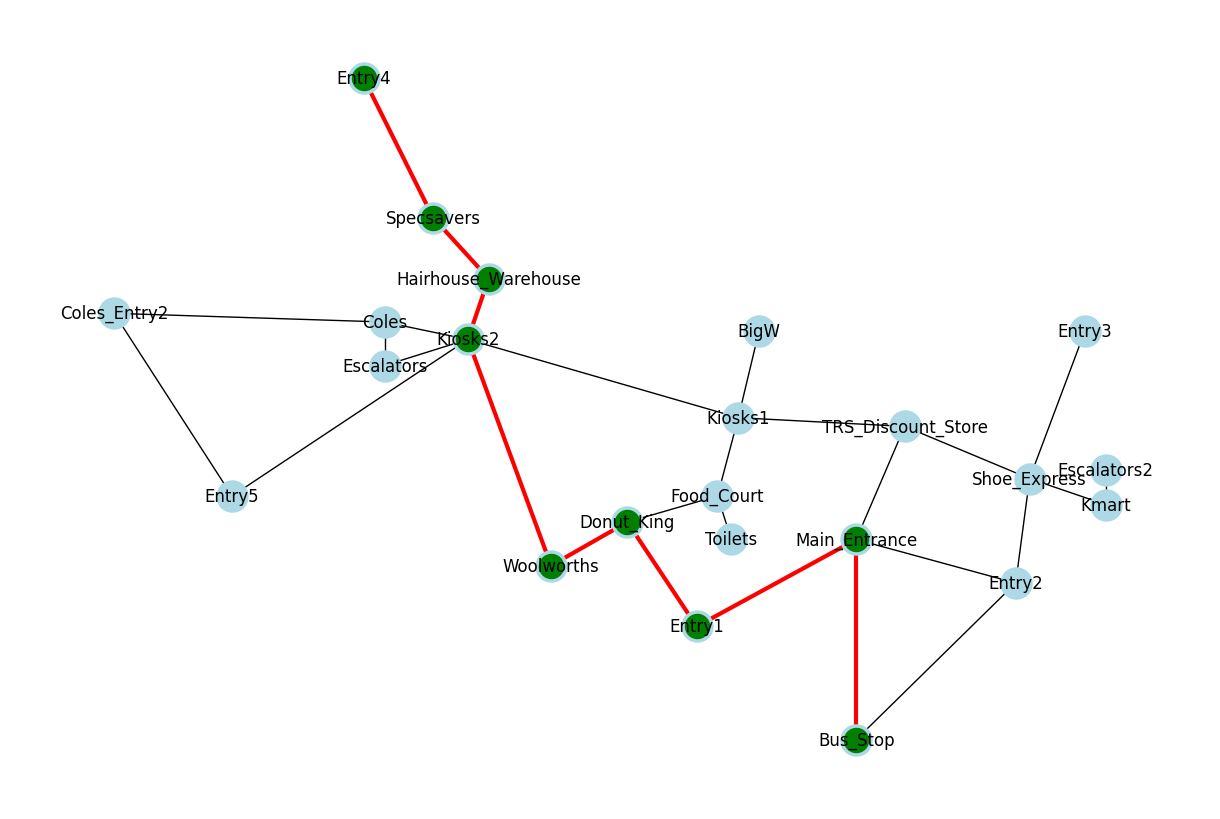

In [25]:
import heapq
import matplotlib.pyplot as plt
import networkx as nx
from functools import lru_cache

# ====================== GRAPH DEFINITION ======================
Parkmore_graph = {
    'Entry1': {'Main_Entrance': 1, 'Donut_King': 1},
    'Entry2': {'Main_Entrance': 1, 'Bus_Stop': 1, 'Shoe_Express': 1},
    'Main_Entrance': {'Entry1': 1, 'Entry2': 1, 'Bus_Stop': 1, 'TRS_Discount_Store': 1},
    'TRS_Discount_Store': {'Main_Entrance': 1, 'Kiosks1': 1, 'Shoe_Express': 1},
    'Shoe_Express': {'Entry2': 1, 'Kmart': 1, 'Entry3': 1, 'TRS_Discount_Store': 1},
    'Kmart': {'Shoe_Express': 1, 'Escalators2': 1},
    'Entry3': {'Shoe_Express': 1},
    'Kiosks1': {'BigW': 1, 'Kiosks2': 2, 'Food_Court': 1, 'TRS_Discount_Store': 1},
    'BigW': {'Kiosks1': 1},
    'Food_Court': {'Toilets': 1, 'Donut_King': 1, 'Kiosks1': 1},
    'Toilets': {'Food_Court': 1},
    'Donut_King': {'Entry1': 1, 'Woolworths': 1, 'Food_Court': 1},
    'Woolworths': {'Donut_King': 1, 'Kiosks2': 2},
    'Kiosks2': {'Hairhouse_Warehouse': 1, 'Kiosks1': 2, 'Woolworths': 2, 'Escalators': 1, 'Coles': 1, 'Entry5': 2},
    'Hairhouse_Warehouse': {'Specsavers': 1, 'Kiosks2': 1},
    'Specsavers': {'Entry4': 1, 'Hairhouse_Warehouse': 1},
    'Entry4': {'Specsavers': 1},
    'Coles': {'Escalators': 1, 'Kiosks2': 1, 'Coles_Entry2': 1},
    'Escalators': {'Coles': 1, 'Kiosks2': 1},
    'Entry5': {'Kiosks2': 2, 'Coles_Entry2': 1},
    'Coles_Entry2': {'Entry5': 1, 'Coles': 1},
    'Bus_Stop': {'Main_Entrance': 1, 'Entry2': 1},
    'Escalators2': {'Kmart': 1}
}

Parkmore_locations = {
    'Entry1': (15.2, 4.5),
    'Entry2': (19.8, 5),
    'Main_Entrance': (17.5, 5.5),
    'TRS_Discount_Store': (18.2, 6.8),
    'Shoe_Express': (20, 6.2),
    'Kmart': (21.1, 5.9),
    'Entry3': (20.8, 7.9),
    'Kiosks1': (15.8, 6.9),
    'BigW': (16.1, 7.9),
    'Food_Court': (15.5, 6),
    'Toilets': (15.7, 5.5),
    'Donut_King': (14.2, 5.7),
    'Woolworths': (13.1, 5.2),
    'Kiosks2': (11.9, 7.8),
    'Hairhouse_Warehouse': (12.2, 8.5),
    'Specsavers': (11.4, 9.2),
    'Entry4': (10.4, 10.8),
    'Coles': (10.7, 8),
    'Escalators': (10.7, 7.5),
    'Entry5': (8.5, 6),
    'Coles_Entry2': (6.8, 8.1),
    'Bus_Stop': (17.5, 3.2),
    'Escalators2': (21.1, 6.3)
}

# ====================== PROBLEM DEFINITION ======================
class GraphProblem:
    def __init__(self, initial, goal, graph_dict, locations):
        self.initial = initial
        self.goal = goal
        self.graph_dict = graph_dict
        self.locations = locations
        
    def h_euclidean(self, node):
        x1, y1 = self.locations[node.state]
        x2, y2 = self.locations[self.goal]
        return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
        
    def h_manhattan(self, node):
        x1, y1 = self.locations[node.state]
        x2, y2 = self.locations[self.goal]
        return abs(x1 - x2) + abs(y1 - y2)
        
    def goal_test(self, state):
        return state == self.goal

# ====================== SEARCH CORE ======================
class Node:
    def __init__(self, state, parent=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.path_cost = path_cost
        
    def expand(self, problem):
        return [Node(neighbor, self, 
                    self.path_cost + problem.graph_dict[self.state][neighbor])
               for neighbor in problem.graph_dict[self.state]]

class PriorityQueue:
    def __init__(self):
        self.heap = []
        
    def push(self, item, priority):
        heapq.heappush(self.heap, (priority, item))
        
    def pop(self):
        return heapq.heappop(self.heap)[1]
        
    def __len__(self):
        return len(self.heap)

# ====================== VISUALIZATION ======================
def draw_graph(graph_dict, locations, solution=None):
    G = nx.Graph(graph_dict)
    pos = locations
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue')
    
    if solution:
        path_edges = [(solution[i], solution[i+1]) 
                     for i in range(len(solution)-1)]
        nx.draw_networkx_nodes(G, pos, nodelist=solution, node_color='green')
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                              edge_color='red', width=3)
    plt.show()

# ====================== A* SEARCH ======================
def astar_search(problem, heuristic='euclidean'):
    h_func = problem.h_euclidean if heuristic == 'euclidean' else problem.h_manhattan
    frontier = PriorityQueue()
    frontier.push(Node(problem.initial), 0)
    explored = set()
    
    while frontier:
        node = frontier.pop()
        
        if problem.goal_test(node.state):
            # Reconstruct path
            path = [node.state]
            while node.parent:
                node = node.parent
                path.append(node.state)
            return path[::-1]
            
        explored.add(node.state)
        
        for child in node.expand(problem):
            if child.state not in explored:
                priority = child.path_cost + h_func(child)
                frontier.push(child, priority)
    
    return None

# ====================== RUN SEARCH ======================
problem = GraphProblem('Bus_Stop', 'Entry4', Parkmore_graph, Parkmore_locations)
solution = astar_search(problem, heuristic='manhattan')

if solution:
    print("Solution Path:", solution)
    draw_graph(Parkmore_graph, Parkmore_locations, solution)
else:
    print("No path found!")